# Curriculum Access Logs Time Series Project

## Initial questions to answer

 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
     - know this for data science cohorts
     - for all = Javascript-i (75K), mysql and html-css both around 55K

 2. Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over? 
     - not for web dev, top 60 by cohort are the same 3-5 lessons, some cohorts may vary in order slightly, but lessons are consistent
     - - regression is more popular for Bayes and Curie, but it was classification for Darden
    - this is most likely because in Bayes and Curie the first big project was in regression but in Darden classification was moved ahead of regression and was the first big project
    
    - also Darden has not yet reached nlp so it does not rank as highly as in the other 2 cohorts
   
   
 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students? 
     - data inaccuracy casts doubt on effectiveness of looking at this metric
     - Overall Population mean and percentiles (note: this is NOT filtered down to only during cohort in session time)
            - Average Accesses per user_id (for full date range in dataset)
            - mean: 659
            - 25%: 133
            - 50%: 728
            - 75%: 1637
  
  
 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents?
     - unable to find oddities without reasonable explaination
     - large usage past grad date for cohort 1 and 14 turned out to be Codeup IP addresses
     - other IP with multiple users appear to be telecom companies masking user IP
     - as expected most cohorts stop accessing after graduation except for a few users
     - more recently graduated cohorts continue to access, particularly during job search and early placement
 
 
 5. At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
    - note there was access in Bayes to Java i and Java ii
    - also in Curie java ii
    - no access from Darden

    - 2 users in Bayes, all access within cohort session
    - first user = 14 observations from Sept and November
    - 2nd user = 3 observations in Dec

    - 1 user in Curie, single access during cohort session


    - not sure if "fundamentals" is used in both curriculum but as of 11/1/2020 there is a user in Bash who is accessing data science curriculum with lessons in anomaly-detection, classification, clustering, distributed-ml, nlp, python, regression, storytelling, and timeseries

    - most other accesses are in 2019 or early 2020, but this current access indicates access has not yet been turned off across the board
  
 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)? 
     - note Darden has not graduated so Data Science refers only to Bayes and Curie
     
    - for data science most common lesson post graduation = SQL 

    - for all = Javascript-i (almost 20K), spring and html-css (both at 15K)

  
 7. Which lessons are least accessed? 
    - know this for data science
    - long list for web dev, but look like pages from appendix or pages that have been replaced (typos) 
  
 8. Anything else I should be aware of? 
     - NOTE: accesses to home page only ("/") have been filtered out
     - if average page viewed per user is under the 25th percentile inaccuracies in user_id assignment and dropped students should be investigated before determining that there are just some student who access the curriculum less overall
    - there are user_id that are substaintially below the mean, but investigation into Darden showed this can be a result of duplicate ids being assigned halfway through class or students who drop from class
    - did not devel deeply into null cohort values

## Deliverables

- link to GitHub notebook that asks and answers questions - document the work you do to justify findings
- email with the answers to the questions/your findings
    - include the link to your notebook in GitHub
    - attach your slide. 
- be sure that the details you need your need your leader to convey/understand are clearly communicated in the email. 
- Slide should be like an Executive Summary and be in form to present, slide notes for speaking points may also be included 

## Environment Setup

In [1]:
import acquire
import prepare
import wrangle
import summarize
import explore

import numpy as np
import pandas as pd
import math
from datetime import datetime
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics

from scipy.stats import entropy

import matplotlib.dates as mdates #to format dates on our plots

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

explore.set_plotting_defaults()

# Acquire

- read in text dataframes

In [2]:
df = acquire.run()

Acquire: downloading raw data files...
Acquire: Completed!


# Prepare
- exp will be dataframe that is a time series as index
- exp_not_ts will have index that is not time series

- set 44,840 null cohort values to 0
- set 1 null page_viewed value to 0
    - shape = (719459, 13)
- drop page_viewed where the entry is only "/"
    - shape = (679337, 10)

In [3]:
exp, exp_not_ts = prepare.run(df)

Prepare: Cleaning acquired data...
Prepare: Completed! Data not split because no modeling at this time. Full dataset returned.


In [4]:
exp.shape

(679337, 17)

In [5]:
exp_not_ts.head()

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
0,2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,0,9,Friday,26,1,2018,2016-02-06,2015-09-22
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,object-oriented-programming,9,Friday,26,1,2018,2016-02-06,2015-09-22
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,slides,object_oriented_programming,9,Friday,26,1,2018,2016-02-06,2015-09-22
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,conditionals,9,Friday,26,1,2018,2018-05-17,2018-01-08
4,2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,loops,9,Friday,26,1,2018,2018-05-17,2018-01-08


In [6]:
exp.shape

(679337, 17)

In [7]:
exp[exp.cohort_id == 0]

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2018-01-26 16:46:24,spring/extra-features/form-validation,48,0,97.105.19.61,0,0,0,0.0,spring,extra-features,16,Friday,26,1,2018,1970-01-01,1970-01-01
2018-01-26 18:32:17,mysql/relationships/joins,48,0,97.105.19.61,0,0,0,0.0,mysql,relationships,18,Friday,26,1,2018,1970-01-01,1970-01-01
2018-01-26 18:32:33,mysql/tables,48,0,97.105.19.61,0,0,0,0.0,mysql,tables,18,Friday,26,1,2018,1970-01-01,1970-01-01
2018-01-26 18:32:37,mysql/databases,48,0,97.105.19.61,0,0,0,0.0,mysql,databases,18,Friday,26,1,2018,1970-01-01,1970-01-01
2018-01-26 18:32:43,mysql/relationships,48,0,97.105.19.61,0,0,0,0.0,mysql,relationships,18,Friday,26,1,2018,1970-01-01,1970-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 16:02:22,java-iii,717,0,136.50.18.157,0,0,0,0.0,java-iii,0,16,Monday,2,11,2020,1970-01-01,1970-01-01
2020-11-02 16:02:26,java-iii/servlets,717,0,136.50.18.157,0,0,0,0.0,java-iii,servlets,16,Monday,2,11,2020,1970-01-01,1970-01-01
2020-11-02 16:03:50,appendix/further-reading/java/intellij-tomcat-...,727,0,70.94.165.107,0,0,0,0.0,appendix,further-reading,16,Monday,2,11,2020,1970-01-01,1970-01-01


In [8]:

# df['newcolumn']
# df.loc[df['program_id'] == #, 'newcolumn'] = value

# Explore

<AxesSubplot:xlabel='cohort_id', ylabel='hour'>

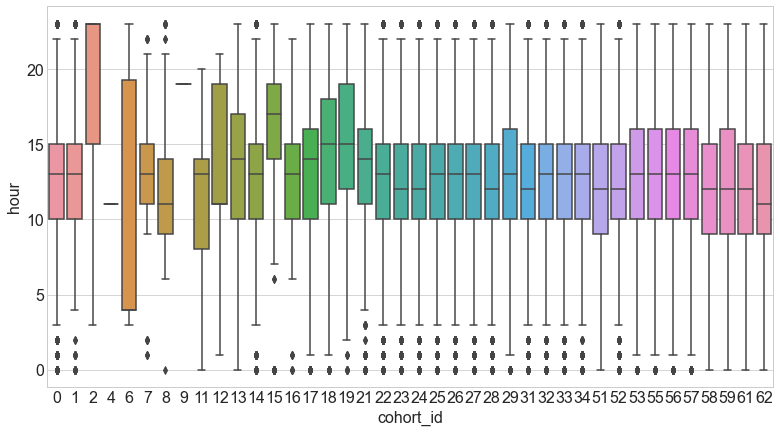

In [9]:
sns.boxplot(data=exp, y='hour', x='cohort_id')

**takeaways**    
- cohort 0 is likely to be instructors
- cohorts 1-3 graduated in 2014
- cohorts 4-9 graduated in 2015
- cohorts 10-14 graduated in 2016
- cohorts 15-20 graduated in 2017
- cohorts 21-25 graduated in 2018
- cohorts 27, 29-33 graduated in 2019
- cohorts 34-58 graduated in 2020
remainder have not yet graduated

- cohort 59 is Darden
- cohort 28 had a name of 'staff' and the date says 2014

Data Science cohorts are program_id 3, the rest would be web dev

Timestamp starts 1/26/2018 so access by cohorts 1 - 20 indicate users who have already graduated. And cohort 21 graduated a month later Feb 2015 so most of their access would be post graduation.


## Isolate Darden cohort as known entity to work on how to find answers to questions
- then attempt to apply out to dataset

In [10]:
darden = exp[exp.name == 'Darden']
darden.head()

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,advanced-topics,1-tidy-data,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:39:37,1-fundamentals/AI-ML-DL-timeline.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,AI-ML-DL-timeline.jpg,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:39:37,1-fundamentals/modern-data-scientist.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,modern-data-scientist.jpg,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:39:53,1-fundamentals/1.1-intro-to-data-science,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,14,Monday,13,7,2020,2021-01-12,2020-07-13


In [11]:
my_ip = '108.239.188.205'
darden[darden.IP == my_ip]

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-07-13 14:39:53,1-fundamentals/1.1-intro-to-data-science,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:39:54,1-fundamentals/modern-data-scientist.jpg,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,fundamentals,modern-data-scientist.jpg,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:39:54,1-fundamentals/AI-ML-DL-timeline.jpg,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,fundamentals,AI-ML-DL-timeline.jpg,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:47:57,3-sql/1-mysql-overview,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,sql,1-mysql-overview,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:48:02,6-regression/1-overview,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,regression,1-overview,14,Monday,13,7,2020,2021-01-12,2020-07-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 12:34:43,sql/database-design,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,sql,database-design,12,Monday,2,11,2020,2021-01-12,2020-07-13
2020-11-02 12:34:51,timeseries/working-with-time-series-data-with-...,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,timeseries,working-with-time-series-data-with-pandas,12,Monday,2,11,2020,2021-01-12,2020-07-13
2020-11-02 12:35:06,timeseries/svr,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,timeseries,svr,12,Monday,2,11,2020,2021-01-12,2020-07-13


In [12]:
dlist = darden.groupby(['user_id'])['IP', 'page_viewed'].\
                        agg({'IP' : ['nunique'], 'page_viewed': ['count']})
dlist

,IP,page_viewed
,nunique,count
user_id,,
268,3,763
678,2,909
679,1,10
680,4,796
681,1,1157
682,4,1012
683,4,150
684,1,792


In [13]:
exp_not_ts.describe()

,user_id,cohort_id,program_id,hour,day,month,year
count,679337.000000,679337.000000,679337.000000,679337.000000,679337.000000,679337.000000,679337.000000
mean,393.593423,34.946989,1.930161,12.852756,15.684743,6.331562,2019.165042
std,210.971734,16.974081,0.607800,4.094047,8.752639,3.110645,0.793624
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2018.000000
25%,231.000000,25.000000,2.000000,10.000000,8.000000,4.000000,2019.000000
50%,417.000000,31.000000,2.000000,13.000000,16.000000,6.000000,2019.000000
75%,568.000000,53.000000,2.000000,15.000000,23.000000,9.000000,2020.000000
max,787.000000,62.000000,4.000000,23.000000,31.000000,12.000000,2020.000000


### Q3 Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [14]:
# filter for active only?
# active_wd = wd[(wd.index >= wd.start_date) & (wd.index <= wd.end_date)]

In [15]:
# what is the population mean and percentile ranks?
# create dataframe by cohort with count of unique users, count of pages viewed, first date accessed, and
# last date accessed
tcohort = exp_not_ts.groupby(['cohort_id'])['program_id', 'start_date', 'end_date', 'user_id', 'page_viewed', 'timestamp'].\
                        agg({'program_id': ['min'], 'start_date': ['min'], 'end_date': ['min'], 'user_id' : ['nunique'], 'page_viewed': ['count'], 'timestamp' : ['min', 'max']})

# use this to unstack the column names
tcohort.columns = [' '.join(col).strip() for col in tcohort.columns.values]

# use this for multiple aggregation
# # df.agg({'A' : ['sum', 'min'], 'B' : ['min', 'max']})

In [16]:
# drop cohort id = 0 (not on Zach's list)
tcohort = tcohort.drop(tcohort.index[0])

In [17]:
tcohort['avg_acc_per_user'] = round(tcohort['page_viewed count']/tcohort['user_id nunique'], 1)
tcohort

,program_id min,start_date min,end_date min,user_id nunique,page_viewed count,timestamp min,timestamp max,avg_acc_per_user
cohort_id,,,,,,,,
1,1.0,2014-02-04,2014-04-22,18,8262,2018-01-26 10:14:51,2020-03-25 23:01:25,459.0
2,1.0,2014-06-04,2014-08-22,3,76,2018-03-19 03:10:04,2019-07-31 16:01:25,25.3
4,1.0,2014-10-20,2015-01-18,1,3,2018-02-04 11:23:27,2018-02-04 11:24:56,3.0
6,1.0,2015-02-03,2015-05-26,2,68,2018-10-16 03:57:11,2019-05-12 21:40:52,34.0
7,1.0,2015-06-05,2015-10-06,6,461,2018-01-31 19:10:00,2019-12-11 09:55:00,76.8
8,1.0,2015-09-22,2016-02-06,5,1502,2018-01-26 09:56:02,2020-04-28 10:58:40,300.4
9,4.0,2015-03-30,2015-07-29,1,4,2018-03-22 19:01:54,2018-03-22 19:02:52,4.0
11,1.0,2016-01-20,2016-05-12,5,200,2018-05-07 20:12:49,2020-07-20 00:42:28,40.0
12,1.0,2016-03-08,2016-06-30,5,294,2018-02-15 19:51:45,2020-08-11 09:46:33,58.8


In [18]:
curie = exp[exp.name == 'Curie']
curie.head()

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-02-03 15:39:34,login,575,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,login,0,15,Monday,3,2,2020,2020-07-07,2020-02-03
2020-02-03 15:39:37,login,575,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,login,0,15,Monday,3,2,2020,2020-07-07,2020-02-03
2020-02-03 15:41:28,login,585,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,login,0,15,Monday,3,2,2020,2020-07-07,2020-02-03
2020-02-03 15:41:59,4-python/1-overview,582,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,python,1-overview,15,Monday,3,2,2020,2020-07-07,2020-02-03
2020-02-03 15:42:04,1-fundamentals/1.1-intro-to-data-science,576,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,fundamentals,1.1-intro-to-data-science,15,Monday,3,2,2020,2020-07-07,2020-02-03


In [19]:
curie.user_id.nunique()
# note Curie graduated 16 students

20

In [20]:
curie.groupby('user_id')['page_viewed'].count().sort_values()

user_id
787       1
577     258
583     432
575     532
587     536
616     575
588     631
578     711
617     747
591     750
589     778
586     893
580    1096
585    1119
582    1218
579    1226
584    1313
590    1482
576    1515
581    3075
Name: page_viewed, dtype: int64

In [21]:
darden.user_id.nunique()
# odd that there are 28 unique user ids when class was max 21 people

28

In [22]:
darden.groupby('user_id')['page_viewed'].count().sort_values()

user_id
679      10
697      12
785      29
780      44
783      52
781      83
683     150
693     324
739     461
694     482
690     577
686     608
695     667
687     671
696     761
268     763
684     792
680     796
678     909
691     932
682    1012
681    1157
692    1232
688    1240
699    1340
698    1420
689    1517
685    2343
Name: page_viewed, dtype: int64

In [23]:
darden.groupby('user_id')['page_viewed'].nunique().sort_values()

# show ids with fewest pages_viewed

user_id
679      4
697      9
783     12
785     13
781     20
780     23
683     46
739     75
693    108
686    126
694    131
690    131
678    133
688    140
687    146
695    146
696    147
691    154
684    154
681    155
680    157
689    158
682    159
268    168
692    178
685    187
699    193
698    213
Name: page_viewed, dtype: int64

In [24]:
darden[darden.user_id == 679]
# IP=24.28.146.155, instructor or staff? only accessed afternoon day 1 and morning day 2

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,advanced-topics,1-tidy-data,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:39:37,1-fundamentals/AI-ML-DL-timeline.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,AI-ML-DL-timeline.jpg,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:39:37,1-fundamentals/modern-data-scientist.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,modern-data-scientist.jpg,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 15:49:31,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 15:49:32,1-fundamentals/modern-data-scientist.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,modern-data-scientist.jpg,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 15:49:32,1-fundamentals/AI-ML-DL-timeline.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,AI-ML-DL-timeline.jpg,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-14 08:05:15,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,8,Tuesday,14,7,2020,2021-01-12,2020-07-13
2020-07-14 08:05:15,1-fundamentals/AI-ML-DL-timeline.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,AI-ML-DL-timeline.jpg,8,Tuesday,14,7,2020,2021-01-12,2020-07-13


In [25]:
darden[darden.user_id == 697]
# IP=136.50.70.27, instructor or staff? only accessed afternoon day 1

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-07-13 15:20:48,3-sql/1-mysql-overview,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,sql,1-mysql-overview,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 15:20:50,1-fundamentals/1.1-intro-to-data-science,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 15:20:50,1-fundamentals/modern-data-scientist.jpg,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,fundamentals,modern-data-scientist.jpg,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 15:20:50,1-fundamentals/AI-ML-DL-timeline.jpg,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,fundamentals,AI-ML-DL-timeline.jpg,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 15:20:59,1-fundamentals/1.2-data-science-pipeline,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.2-data-science-pipeline,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 15:20:59,1-fundamentals/DataToAction_v2.jpg,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,fundamentals,DataToAction_v2.jpg,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 15:21:01,1-fundamentals/1.1-intro-to-data-science,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 15:21:02,1-fundamentals/AI-ML-DL-timeline.jpg,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,fundamentals,AI-ML-DL-timeline.jpg,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 15:21:02,1-fundamentals/modern-data-scientist.jpg,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,fundamentals,modern-data-scientist.jpg,15,Monday,13,7,2020,2021-01-12,2020-07-13


In [26]:
darden[darden.user_id == 785]
# IP=72.181.127.233, didn't start accessing until October

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-10-26 14:35:01,timeseries/acquire,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,timeseries,acquire,14,Monday,26,10,2020,2021-01-12,2020-07-13
2020-10-27 09:13:52,working-with-time-series-data,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,working-with-time-series-data,0,9,Tuesday,27,10,2020,2021-01-12,2020-07-13
2020-10-27 09:13:55,working-with-time-series-data,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,working-with-time-series-data,0,9,Tuesday,27,10,2020,2021-01-12,2020-07-13
2020-10-27 09:13:57,working-with-time-series-data,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,working-with-time-series-data,0,9,Tuesday,27,10,2020,2021-01-12,2020-07-13
2020-10-27 09:14:02,working-with-time-series-data,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,working-with-time-series-data,0,9,Tuesday,27,10,2020,2021-01-12,2020-07-13
2020-10-27 09:14:14,sql/mysql-overview,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,sql,mysql-overview,9,Tuesday,27,10,2020,2021-01-12,2020-07-13
2020-10-27 09:14:14,classification/overview,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,classification,overview,9,Tuesday,27,10,2020,2021-01-12,2020-07-13
2020-10-27 09:14:14,classification/scale_features_or_not.svg,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,classification,scale_features_or_not.svg,9,Tuesday,27,10,2020,2021-01-12,2020-07-13
2020-10-27 09:14:20,timeseries/overview,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,timeseries,overview,9,Tuesday,27,10,2020,2021-01-12,2020-07-13


In [27]:
darden[darden.user_id == 780]
# IP=99.132.128.255 didn't start accessing until October

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-10-22 14:21:19,timeseries/overview,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,timeseries,overview,14,Thursday,22,10,2020,2021-01-12,2020-07-13
2020-10-22 15:35:22,timeseries/acquire,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,timeseries,acquire,15,Thursday,22,10,2020,2021-01-12,2020-07-13
2020-10-22 18:40:09,regression/acquire-and-prep,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,regression,acquire-and-prep,18,Thursday,22,10,2020,2021-01-12,2020-07-13
2020-10-22 18:41:01,regression/split-and-scale,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,regression,split-and-scale,18,Thursday,22,10,2020,2021-01-12,2020-07-13
2020-10-22 18:42:11,regression/explore,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,regression,explore,18,Thursday,22,10,2020,2021-01-12,2020-07-13
2020-10-22 18:43:55,regression/evaluate,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,regression,evaluate,18,Thursday,22,10,2020,2021-01-12,2020-07-13
2020-10-22 18:44:54,regression/feature-engineering,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,regression,feature-engineering,18,Thursday,22,10,2020,2021-01-12,2020-07-13
2020-10-22 18:47:04,regression/model,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,regression,model,18,Thursday,22,10,2020,2021-01-12,2020-07-13
2020-10-22 18:47:40,regression/project,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,regression,project,18,Thursday,22,10,2020,2021-01-12,2020-07-13


In [28]:
darden[darden.user_id == 783]
# IP=70.120.16.59, didn't start accessing until October

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-10-25 14:34:13,classification/overview,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,classification,overview,14,Sunday,25,10,2020,2021-01-12,2020-07-13
2020-10-25 14:34:13,classification/scale_features_or_not.svg,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,classification,scale_features_or_not.svg,14,Sunday,25,10,2020,2021-01-12,2020-07-13
2020-10-25 14:34:16,timeseries/project,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,timeseries,project,14,Sunday,25,10,2020,2021-01-12,2020-07-13
2020-10-25 14:36:54,timeseries/overview,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,timeseries,overview,14,Sunday,25,10,2020,2021-01-12,2020-07-13
2020-10-25 14:40:18,timeseries/acquire,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,timeseries,acquire,14,Sunday,25,10,2020,2021-01-12,2020-07-13
2020-10-25 14:59:52,timeseries/working-with-time-series-data,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,timeseries,working-with-time-series-data,14,Sunday,25,10,2020,2021-01-12,2020-07-13
2020-10-27 07:44:50,timeseries/prep,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,timeseries,prep,7,Tuesday,27,10,2020,2021-01-12,2020-07-13
2020-10-27 07:49:46,timeseries/project,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,timeseries,project,7,Tuesday,27,10,2020,2021-01-12,2020-07-13
2020-10-27 07:49:50,timeseries/explore,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,timeseries,explore,7,Tuesday,27,10,2020,2021-01-12,2020-07-13


In [29]:
darden[darden.user_id == 781]
# IP=108.239.188.205, didn't start accessing until October
# this is actally ME!! I have 2 user ids 681 and 781

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-10-26 08:38:56,classification/overview,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,classification,overview,8,Monday,26,10,2020,2021-01-12,2020-07-13
2020-10-26 08:38:57,classification/scale_features_or_not.svg,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,classification,scale_features_or_not.svg,8,Monday,26,10,2020,2021-01-12,2020-07-13
2020-10-26 08:39:02,timeseries/working-with-time-series-data,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,timeseries,working-with-time-series-data,8,Monday,26,10,2020,2021-01-12,2020-07-13
2020-10-26 09:20:13,timeseries/acquire,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,timeseries,acquire,9,Monday,26,10,2020,2021-01-12,2020-07-13
2020-10-26 11:54:27,timeseries/acquire,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,timeseries,acquire,11,Monday,26,10,2020,2021-01-12,2020-07-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 12:34:43,sql/database-design,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,sql,database-design,12,Monday,2,11,2020,2021-01-12,2020-07-13
2020-11-02 12:34:51,timeseries/working-with-time-series-data-with-...,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,timeseries,working-with-time-series-data-with-pandas,12,Monday,2,11,2020,2021-01-12,2020-07-13
2020-11-02 12:35:06,timeseries/svr,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,timeseries,svr,12,Monday,2,11,2020,2021-01-12,2020-07-13


In [30]:
darden[darden.user_id == 683]
# IP=173.174.165.12, started in July but last access in August = Chris Mora?

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-07-13 15:11:07,1-fundamentals/1.1-intro-to-data-science,683,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 15:11:07,1-fundamentals/modern-data-scientist.jpg,683,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,fundamentals,modern-data-scientist.jpg,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 15:11:07,1-fundamentals/AI-ML-DL-timeline.jpg,683,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,fundamentals,AI-ML-DL-timeline.jpg,15,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 19:16:24,1-fundamentals/1.1-intro-to-data-science,683,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,19,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 19:16:24,1-fundamentals/modern-data-scientist.jpg,683,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,fundamentals,modern-data-scientist.jpg,19,Monday,13,7,2020,2021-01-12,2020-07-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-07 08:55:43,python/data-types-and-variables,683,59,70.120.73.115,Darden,2020-07-13,2021-01-12,3.0,python,data-types-and-variables,8,Friday,7,8,2020,2021-01-12,2020-07-13
2020-08-07 09:27:52,python/intro-to-matplotlib,683,59,70.120.73.115,Darden,2020-07-13,2021-01-12,3.0,python,intro-to-matplotlib,9,Friday,7,8,2020,2021-01-12,2020-07-13
2020-08-07 11:47:27,python/intro-to-matplotlib,683,59,107.77.222.115,Darden,2020-07-13,2021-01-12,3.0,python,intro-to-matplotlib,11,Friday,7,8,2020,2021-01-12,2020-07-13


In [31]:
darden[darden.user_id == 693]
# IP=136.50.3.247, started in July and continues through present

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-07-13 14:47:15,1-fundamentals/1.1-intro-to-data-science,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:47:15,1-fundamentals/modern-data-scientist.jpg,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,fundamentals,modern-data-scientist.jpg,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:47:15,1-fundamentals/AI-ML-DL-timeline.jpg,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,fundamentals,AI-ML-DL-timeline.jpg,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-14 16:10:56,appendix/documentation,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,appendix,documentation,16,Tuesday,14,7,2020,2021-01-12,2020-07-13
2020-07-14 16:11:44,1-fundamentals/1.1-intro-to-data-science,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,16,Tuesday,14,7,2020,2021-01-12,2020-07-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-28 10:45:26,timeseries/prep,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,timeseries,prep,10,Wednesday,28,10,2020,2021-01-12,2020-07-13
2020-10-28 11:21:27,timeseries/explore,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,timeseries,explore,11,Wednesday,28,10,2020,2021-01-12,2020-07-13
2020-10-29 10:12:56,timeseries/explore,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,timeseries,explore,10,Thursday,29,10,2020,2021-01-12,2020-07-13


In [32]:
darden[darden.user_id == 739]
# IP=173.174.165.12, started in Aug and continues through Oct = Gabby?

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-08-07 19:17:51,python/intro-to-matplotlib,739,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,python,intro-to-matplotlib,19,Friday,7,8,2020,2021-01-12,2020-07-13
2020-08-07 19:18:16,fundamentals/git,739,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,fundamentals,git,19,Friday,7,8,2020,2021-01-12,2020-07-13
2020-08-07 19:29:05,python/intro-to-numpy,739,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,python,intro-to-numpy,19,Friday,7,8,2020,2021-01-12,2020-07-13
2020-08-10 11:22:19,python/intro-to-numpy,739,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,python,intro-to-numpy,11,Monday,10,8,2020,2021-01-12,2020-07-13
2020-08-10 13:33:55,python/intro-to-numpy,739,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,python,intro-to-numpy,13,Monday,10,8,2020,2021-01-12,2020-07-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-20 13:32:10,clustering/model,739,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,clustering,model,13,Tuesday,20,10,2020,2021-01-12,2020-07-13
2020-10-20 14:45:47,clustering/explore,739,59,107.77.219.35,Darden,2020-07-13,2021-01-12,3.0,clustering,explore,14,Tuesday,20,10,2020,2021-01-12,2020-07-13
2020-10-20 14:45:48,clustering/explore,739,59,107.77.219.35,Darden,2020-07-13,2021-01-12,3.0,clustering,explore,14,Tuesday,20,10,2020,2021-01-12,2020-07-13


In [33]:
darden[darden.user_id == 694]
# IP=96.8.130.186, started in JULY and continues through present

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-07-13 23:36:01,4-python/4-control-structures,694,59,96.8.130.186,Darden,2020-07-13,2021-01-12,3.0,python,4-control-structures,23,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-14 06:03:25,4-python/5-functions,694,59,96.8.130.186,Darden,2020-07-13,2021-01-12,3.0,python,5-functions,6,Tuesday,14,7,2020,2021-01-12,2020-07-13
2020-07-14 06:06:03,4-python/6-imports,694,59,96.8.130.186,Darden,2020-07-13,2021-01-12,3.0,python,6-imports,6,Tuesday,14,7,2020,2021-01-12,2020-07-13
2020-07-14 06:06:39,4-python/4-control-structures,694,59,96.8.130.186,Darden,2020-07-13,2021-01-12,3.0,python,4-control-structures,6,Tuesday,14,7,2020,2021-01-12,2020-07-13
2020-07-14 06:07:38,4-python/7-working-with-files,694,59,96.8.130.186,Darden,2020-07-13,2021-01-12,3.0,python,7-working-with-files,6,Tuesday,14,7,2020,2021-01-12,2020-07-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-29 09:01:01,timeseries/modeling-lesson1,694,59,96.8.130.240,Darden,2020-07-13,2021-01-12,3.0,timeseries,modeling-lesson1,9,Thursday,29,10,2020,2021-01-12,2020-07-13
2020-10-29 09:08:39,timeseries/explore,694,59,96.8.130.240,Darden,2020-07-13,2021-01-12,3.0,timeseries,explore,9,Thursday,29,10,2020,2021-01-12,2020-07-13
2020-10-29 11:08:41,regression/split-and-scale,694,59,96.8.130.240,Darden,2020-07-13,2021-01-12,3.0,regression,split-and-scale,11,Thursday,29,10,2020,2021-01-12,2020-07-13


In [34]:
co_user_views = darden.groupby('user_id')[['page_viewed']].count().describe()

In [35]:
co_user_views

,page_viewed
count,28.000000
mean,728.000000
std,560.467265
min,10.000000
25%,280.500000
50%,716.000000
75%,1048.250000
max,2343.000000


In [36]:
tcohort.describe()

,program_id min,user_id nunique,page_viewed count,avg_acc_per_user
count,39.000000,39.000000,39.000000,39.000000
mean,1.820513,18.948718,16372.948718,658.558974
std,0.683328,10.696652,14603.434569,505.742980
min,1.000000,1.000000,3.000000,3.000000
25%,1.000000,8.500000,1264.500000,132.800000
50%,2.000000,22.000000,18888.000000,728.000000
75%,2.000000,28.000000,27287.000000,1032.700000
max,4.000000,35.000000,55682.000000,1637.700000


#### Q3 Answers
- note there are duplicated user_ids (single student with multiple id #s)
    - this makes knowing the total pages per user suspect
- Darden had 2 students drop midway through program (and maybe 2 on first day?)
- 4 user_ids are likely duplicates so just looking at user_id under a certain % doesn't really indicate that the student is below average in use

If duplication and dropped IDs are common throughout this casts doubt on the accuracy mean student usage

Overall Population mean and percentiles (note: this is NOT filtered down to only during cohort in session time)
Average Accesses per user_id (for full date range in dataset)
mean: 659
25%: 133
50%: 728
75%: 1637


In [37]:
# views_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [38]:
clist = set(exp.name.to_list())

# for name in clist:
#     cgroup = exp[exp.name == name]
#     user_views = cgroup.groupby('user_id')['page_viewed'].count().describe()
# #     user_views.columns=[name]
#     co_user_views.append(user_views)


### Q1 Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [39]:
# create df of only active
# active_wd = wd[(wd.index >= wd.start_date) & (wd.index <= wd.end_date)]
active = exp_not_ts[(exp_not_ts.timestamp >= exp_not_ts.start_date_ts) & (exp_not_ts.timestamp <= exp_not_ts.end_date_ts)]
active.shape

(495294, 18)

In [40]:
active

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,conditionals,9,Friday,26,1,2018,2018-05-17,2018-01-08
4,2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,loops,9,Friday,26,1,2018,2018-05-17,2018-01-08
5,2018-01-26 09:56:46,javascript-i/conditionals,3,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,conditionals,9,Friday,26,1,2018,2018-05-17,2018-01-08
6,2018-01-26 09:56:48,javascript-i/functions,3,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,functions,9,Friday,26,1,2018,2018-05-17,2018-01-08
7,2018-01-26 09:56:59,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,loops,9,Friday,26,1,2018,2018-05-17,2018-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679332,2020-11-02 16:48:13,javascript-i/coffee-project,763,62,107.192.148.199,Jupiter,2020-09-21,2021-03-30,2.0,javascript-i,coffee-project,16,Monday,2,11,2020,2021-03-30,2020-09-21
679333,2020-11-02 16:48:17,javascript-i/mapbox-api,771,62,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0,javascript-i,mapbox-api,16,Monday,2,11,2020,2021-03-30,2020-09-21
679334,2020-11-02 16:48:18,javascript-i/coffee-project,771,62,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0,javascript-i,coffee-project,16,Monday,2,11,2020,2021-03-30,2020-09-21
679335,2020-11-02 16:48:28,javascript-i/bom-and-dom/bom,771,62,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0,javascript-i,bom-and-dom,16,Monday,2,11,2020,2021-03-30,2020-09-21


In [41]:
# sort for highest count lesson
all_active = active.groupby(['lesson'])[['sub_lesson']].count().reset_index()
all_active.sort_values(by='sub_lesson', ascending = False).head(25)

,lesson,sub_lesson
127,javascript-i,74819
146,mysql,56350
110,html-css,55058
131,jquery,39330
123,java-ii,35032
124,java-iii,34812
190,spring,32044
122,java-i,25733
128,javascript-ii,25154
46,appendix,19718


In [42]:
active

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,conditionals,9,Friday,26,1,2018,2018-05-17,2018-01-08
4,2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,loops,9,Friday,26,1,2018,2018-05-17,2018-01-08
5,2018-01-26 09:56:46,javascript-i/conditionals,3,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,conditionals,9,Friday,26,1,2018,2018-05-17,2018-01-08
6,2018-01-26 09:56:48,javascript-i/functions,3,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,functions,9,Friday,26,1,2018,2018-05-17,2018-01-08
7,2018-01-26 09:56:59,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,loops,9,Friday,26,1,2018,2018-05-17,2018-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679332,2020-11-02 16:48:13,javascript-i/coffee-project,763,62,107.192.148.199,Jupiter,2020-09-21,2021-03-30,2.0,javascript-i,coffee-project,16,Monday,2,11,2020,2021-03-30,2020-09-21
679333,2020-11-02 16:48:17,javascript-i/mapbox-api,771,62,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0,javascript-i,mapbox-api,16,Monday,2,11,2020,2021-03-30,2020-09-21
679334,2020-11-02 16:48:18,javascript-i/coffee-project,771,62,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0,javascript-i,coffee-project,16,Monday,2,11,2020,2021-03-30,2020-09-21
679335,2020-11-02 16:48:28,javascript-i/bom-and-dom/bom,771,62,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0,javascript-i,bom-and-dom,16,Monday,2,11,2020,2021-03-30,2020-09-21


In [43]:
# # split the page viewed column to get program language and lesson
# program_lesson = exp.page_viewed.str.split('/', expand=True)
# program_lesson = program_lesson.drop(columns=[2, 3, 4, 5, 6, 7])
# program_lesson.columns = ['lesson', 'sub_lesson']
# program_lesson['lesson'] = program_lesson.lesson.str.strip('0123456789-!?')
# program_lesson['lesson'] = program_lesson.lesson.str.strip('.123-!?')
# exp = pd.concat([exp, program_lesson], axis=1)
# # removed dropping of page_viewed column: .drop(columns='page_viewed')
# exp

In [44]:
# check for null values
exp.isna().sum()

page_viewed      0
user_id          0
cohort_id        0
IP               0
name             0
start_date       0
end_date         0
program_id       0
lesson           0
sub_lesson       0
hour             0
weekday          0
day              0
month            0
year             0
end_date_ts      0
start_date_ts    0
dtype: int64

In [45]:
# # fill null with 0
# exp = exp.fillna(0)
# exp.isna().sum()

In [46]:
data_science = exp[exp.program_id == 3]
data_science

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2019-08-20 09:40:28,3-sql/1-mysql-overview,470,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,sql,1-mysql-overview,9,Tuesday,20,8,2019,2020-01-30,2019-08-19
2019-08-20 09:40:30,2-storytelling/bad-charts,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,storytelling,bad-charts,9,Tuesday,20,8,2019,2020-01-30,2019-08-19
2019-08-20 09:40:30,2-storytelling/misleading1_baseball.jpg,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,storytelling,misleading1_baseball.jpg,9,Tuesday,20,8,2019,2020-01-30,2019-08-19
2019-08-20 09:40:30,2-storytelling/misleading1_fox.jpg,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,storytelling,misleading1_fox.jpg,9,Tuesday,20,8,2019,2020-01-30,2019-08-19
2019-08-20 09:40:30,2-storytelling/misleading3_deaths.jpg,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,storytelling,misleading3_deaths.jpg,9,Tuesday,20,8,2019,2020-01-30,2019-08-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 15:48:14,appendix/interview_questions_students,698,59,24.28.150.196,Darden,2020-07-13,2021-01-12,3.0,appendix,interview_questions_students,15,Monday,2,11,2020,2021-01-12,2020-07-13
2020-11-02 15:50:07,appendix/open_data,698,59,24.28.150.196,Darden,2020-07-13,2021-01-12,3.0,appendix,open_data,15,Monday,2,11,2020,2021-01-12,2020-07-13
2020-11-02 15:52:23,timeseries/sarimax,698,59,24.28.150.196,Darden,2020-07-13,2021-01-12,3.0,timeseries,sarimax,15,Monday,2,11,2020,2021-01-12,2020-07-13


In [47]:
data_science.groupby('lesson')[['sub_lesson']].count().sort_values(by='sub_lesson', ascending=False)

,sub_lesson
lesson,
fundamentals,9199
sql,8451
python,7314
classification,7307
regression,5949
...,...
git,1
%20https:,1
imports,1


#### Q1 Answers
- note the dataset only has Bayes, Curie, and Darden datascience cohorts
- there are 97 lesson topics and 342 sub lesson topics
- most popular across data science cohorts:
    - fundamentals	9199
    - sql	8451
    - python	7314
    - classification	7307
    - regression	5949

### Q7 Which lessons are least accessed?

In [48]:
webactive = active[(active.program_id == 2) | (active.program_id == 1)]

In [49]:

webactive_least = webactive.groupby(['lesson'])[['sub_lesson']].count().reset_index()
webactive_least.sort_values(by='sub_lesson', ascending = True).head(60)

,lesson,sub_lesson
76,index.html,1
117,quic,1
116,query,1
29,annotations,1
32,arash-arghavan,1
106,ordinary_least_squares.jpeg,1
34,asset-manifest.json,1
105,one,1
102,mysql-introduction,1
96,main-pages_xXxXx.html,1


In [50]:
data_science.groupby('lesson')[['sub_lesson']].count().sort_values(by='sub_lesson', ascending=True).head(60)

,sub_lesson
lesson,
0,1
explore,1
database-design,1
git,1
imports,1
index.html,1
curie-statistics-assessment,1
itc%20-%20ml,1
itc-ml,1


#### Q7 Answers
- note the dataset only has Bayes, Curie, and Darden datascience cohorts
- there are 97 lesson topics and 342 sub lesson topics
- least accessed lessons grouped by topic (pictures, assessments, etc. have been removed):
explore	1
database-design	1
git	1
imports	1
itc-ml	1
capstones	1
mkdocs	1
bad-charts	1
detecting-with-clustering	1
b-clustering	1
4.1-pandas-overview	1
4.2-series	1
vocabulary	1
A-clustering	1
statistics-assessment	1
end_to_end_clustering	1
spreadsheets-overview	1
scale_features_or_not.svg	1
End_to_End_clustering	1
ltc.-ml	2
probability-distributions	2
intro-to-matplotlib	2
split-and-scale	2
functions	2
project	2
prep	2
examples	2
present	2
AnomalyDetectionCartoon.jpeg	2
detecting-timeseries-anomalies	2
databases	2
api	2
data-types-and-variables	2
5-more-statistical-testing-examples	2
create	2
compare-means	3
mysql	3
simulation	3
refine	3
cli	3



### Q2 Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over?

In [51]:
webactive

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,conditionals,9,Friday,26,1,2018,2018-05-17,2018-01-08
4,2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,loops,9,Friday,26,1,2018,2018-05-17,2018-01-08
5,2018-01-26 09:56:46,javascript-i/conditionals,3,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,conditionals,9,Friday,26,1,2018,2018-05-17,2018-01-08
6,2018-01-26 09:56:48,javascript-i/functions,3,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,functions,9,Friday,26,1,2018,2018-05-17,2018-01-08
7,2018-01-26 09:56:59,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,loops,9,Friday,26,1,2018,2018-05-17,2018-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679332,2020-11-02 16:48:13,javascript-i/coffee-project,763,62,107.192.148.199,Jupiter,2020-09-21,2021-03-30,2.0,javascript-i,coffee-project,16,Monday,2,11,2020,2021-03-30,2020-09-21
679333,2020-11-02 16:48:17,javascript-i/mapbox-api,771,62,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0,javascript-i,mapbox-api,16,Monday,2,11,2020,2021-03-30,2020-09-21
679334,2020-11-02 16:48:18,javascript-i/coffee-project,771,62,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0,javascript-i,coffee-project,16,Monday,2,11,2020,2021-03-30,2020-09-21
679335,2020-11-02 16:48:28,javascript-i/bom-and-dom/bom,771,62,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0,javascript-i,bom-and-dom,16,Monday,2,11,2020,2021-03-30,2020-09-21


In [52]:
webcoact = webactive.groupby(['cohort_id', 'lesson'])[['sub_lesson']].count().reset_index()
webcoact.sort_values(by='sub_lesson', ascending = False).head(60)

,cohort_id,lesson,sub_lesson
322,33,javascript-i,6185
316,33,html-css,5540
228,29,javascript-i,5282
497,58,javascript-i,5046
290,32,javascript-i,4907
88,24,javascript-i,4762
406,53,javascript-i,4724
116,25,javascript-i,4493
232,29,mysql,4404
95,24,mysql,4323


In [53]:
darden = exp[exp.name == 'Darden']
darden.head()

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,advanced-topics,1-tidy-data,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:39:37,1-fundamentals/AI-ML-DL-timeline.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,AI-ML-DL-timeline.jpg,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:39:37,1-fundamentals/modern-data-scientist.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,fundamentals,modern-data-scientist.jpg,14,Monday,13,7,2020,2021-01-12,2020-07-13
2020-07-13 14:39:53,1-fundamentals/1.1-intro-to-data-science,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,fundamentals,1.1-intro-to-data-science,14,Monday,13,7,2020,2021-01-12,2020-07-13


In [54]:
darden.groupby('lesson')[['sub_lesson']].count().sort_values(by='sub_lesson', ascending=False)

,sub_lesson
lesson,
classification,3842
fundamentals,3708
sql,3263
python,2408
stats,1921
regression,1299
clustering,1013
storytelling,890
appendix,688


In [55]:
data_science = exp[exp.program_id == 3]
data_science.nunique()

page_viewed      596
user_id           71
cohort_id          3
IP               551
name               3
start_date         3
end_date           3
program_id         1
lesson            97
sub_lesson       342
hour              24
weekday            7
day               31
month             12
year               2
end_date_ts        3
start_date_ts      3
dtype: int64

In [56]:
bayes = exp[exp.name == 'Bayes']
bayes.head()

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2019-08-20 09:40:28,3-sql/1-mysql-overview,470,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,sql,1-mysql-overview,9,Tuesday,20,8,2019,2020-01-30,2019-08-19
2019-08-20 09:40:30,2-storytelling/bad-charts,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,storytelling,bad-charts,9,Tuesday,20,8,2019,2020-01-30,2019-08-19
2019-08-20 09:40:30,2-storytelling/misleading1_baseball.jpg,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,storytelling,misleading1_baseball.jpg,9,Tuesday,20,8,2019,2020-01-30,2019-08-19
2019-08-20 09:40:30,2-storytelling/misleading1_fox.jpg,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,storytelling,misleading1_fox.jpg,9,Tuesday,20,8,2019,2020-01-30,2019-08-19
2019-08-20 09:40:30,2-storytelling/misleading3_deaths.jpg,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,storytelling,misleading3_deaths.jpg,9,Tuesday,20,8,2019,2020-01-30,2019-08-19


In [57]:
bayes.groupby('lesson')[['sub_lesson']].count().sort_values(by='sub_lesson', ascending=False)

,sub_lesson
lesson,
fundamentals,3110
regression,2630
python,2447
sql,2360
classification,2016
stats,1988
clustering,1361
appendix,1231
anomaly-detection,1201


In [58]:
curie = exp[exp.name == 'Curie']
curie.head()

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2020-02-03 15:39:34,login,575,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,login,0,15,Monday,3,2,2020,2020-07-07,2020-02-03
2020-02-03 15:39:37,login,575,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,login,0,15,Monday,3,2,2020,2020-07-07,2020-02-03
2020-02-03 15:41:28,login,585,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,login,0,15,Monday,3,2,2020,2020-07-07,2020-02-03
2020-02-03 15:41:59,4-python/1-overview,582,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,python,1-overview,15,Monday,3,2,2020,2020-07-07,2020-02-03
2020-02-03 15:42:04,1-fundamentals/1.1-intro-to-data-science,576,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,fundamentals,1.1-intro-to-data-science,15,Monday,3,2,2020,2020-07-07,2020-02-03


In [59]:
curie.groupby('lesson')[['sub_lesson']].count().sort_values(by='sub_lesson', ascending=False)

,sub_lesson
lesson,
sql,2828
python,2459
fundamentals,2381
regression,2020
classification,1449
stats,1325
appendix,1106
anomaly-detection,1000
nlp,793


In [60]:
exp.head()


,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,0,9,Friday,26,1,2018,2016-02-06,2015-09-22
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,object-oriented-programming,9,Friday,26,1,2018,2016-02-06,2015-09-22
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,slides,object_oriented_programming,9,Friday,26,1,2018,2016-02-06,2015-09-22
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,conditionals,9,Friday,26,1,2018,2018-05-17,2018-01-08
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,loops,9,Friday,26,1,2018,2018-05-17,2018-01-08


In [61]:
lesson_groups = exp.groupby(['program_id', 'cohort_id', 'lesson'])[['sub_lesson']].count().reset_index()

In [62]:
ds_lesson = lesson_groups[lesson_groups.program_id == 3]

In [63]:
ds_lesson[ds_lesson.sub_lesson > 1000].sort_values(by='sub_lesson', ascending=False)

,program_id,cohort_id,lesson,sub_lesson
2031,3.0,59,classification,3842
2040,3.0,59,fundamentals,3708
2059,3.0,59,sql,3263
1954,3.0,34,fundamentals,3110
2018,3.0,55,sql,2828
1976,3.0,34,regression,2630
2015,3.0,55,python,2459
1975,3.0,34,python,2447
2050,3.0,59,python,2408
2007,3.0,55,fundamentals,2381


#### Q2 Answers

- regression is more popular for Bayes and Curie, but it was classification for Darden
    - this is most likely because in Bayes and Curie the first big project was in regression but in Darden classification was moved ahead of regression and was the first big project
- also Darden has not yet reached nlp so it does not rank as highly as in the other 2 cohorts

### Q5 At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

In [64]:
exp_not_ts.head()

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
0,2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,0,9,Friday,26,1,2018,2016-02-06,2015-09-22
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,object-oriented-programming,9,Friday,26,1,2018,2016-02-06,2015-09-22
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,slides,object_oriented_programming,9,Friday,26,1,2018,2016-02-06,2015-09-22
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,conditionals,9,Friday,26,1,2018,2018-05-17,2018-01-08
4,2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,loops,9,Friday,26,1,2018,2018-05-17,2018-01-08


In [65]:
# basing data science curriculum list on Darden because Bayes and Curie both have Java in their lists
ds_cur = exp_not_ts[exp_not_ts.cohort_id == 59].lesson

In [66]:
ds_cur = ds_cur.to_list()

In [67]:
set(ds_cur)

{'AI-ML-DL-timeline.jpg',
 'acquire',
 'advanced-topics',
 'anomaly-detection',
 'api',
 'appendix',
 'bad-charts',
 'classification',
 'clustering',
 'compare-means',
 'create',
 'darden-python-assessment.html',
 'data-science-pipeline',
 'distributed-ml',
 'explore',
 'functions',
 'fundamentals',
 'imports',
 'intro-to-matplotlib',
 'modern-data-scientist.jpg',
 'nlp',
 'overview',
 'pandas-overview',
 'pipeline-demo',
 'prep',
 'present',
 'python',
 'refine',
 'regression',
 'scale_features_or_not.svg',
 'search',
 'series',
 'simulation',
 'split-and-scale',
 'spreadsheets-overview',
 'sql',
 'stats',
 'storytelling',
 'timeseries',
 'vocabulary',
 'working-with-time-series-data'}

In [68]:
# df with no datascience cohorts
webonly = exp_not_ts[exp_not_ts.program_id != 3]

In [69]:
# webonly where the lesson is in the list of data science curriculum
web_crossover = webonly[webonly.lesson.isin(ds_cur)]

In [70]:
# dropping appendix because that is in both
web_crossover.drop(web_crossover[web_crossover['lesson'] == 'appendix'].index, inplace = True)

In [71]:
# dropping all known staff
web_crossover.drop(web_crossover[web_crossover['name'] == 'Staff'].index, inplace = True)

In [72]:
# dropping search because it is too generic a term and may be equally valid
web_crossover.drop(web_crossover[web_crossover['lesson'] == 'search'].index, inplace = True)

In [73]:
# dropping advanced topics because the sublessons are very different
web_crossover.drop(web_crossover[web_crossover['lesson'] == 'advanced-topics'].index, inplace = True)

In [74]:
# dropping cohort 0 because only interested in identifiable cohorts
web_crossover.drop(web_crossover[web_crossover['cohort_id'] == 0].index, inplace = True)

In [75]:
web_crossover

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
25952,2018-03-19 08:21:41,functions,145,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19,2.0,functions,0,8,Monday,19,3,2018,2018-07-19,2018-03-05
25953,2018-03-19 08:21:46,functions,145,23,97.105.19.61,Ulysses,2018-03-05,2018-07-19,2.0,functions,0,8,Monday,19,3,2018,2018-07-19,2018-03-05
37881,2018-04-08 13:56:25,fundamentals/controllers,155,22,70.123.231.211,Teddy,2018-01-08,2018-05-17,2.0,fundamentals,controllers,13,Sunday,8,4,2018,2018-05-17,2018-01-08
37882,2018-04-08 13:56:31,fundamentals/controllers,155,22,70.123.231.211,Teddy,2018-01-08,2018-05-17,2.0,fundamentals,controllers,13,Sunday,8,4,2018,2018-05-17,2018-01-08
37883,2018-04-08 13:56:38,fundamentals/views,155,22,70.123.231.211,Teddy,2018-01-08,2018-05-17,2.0,fundamentals,views,13,Sunday,8,4,2018,2018-05-17,2018-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677459,2020-11-01 02:57:00,distributed-ml/environment-setup,730,61,68.203.188.247,Bash,2020-07-20,2021-01-21,2.0,distributed-ml,environment-setup,2,Sunday,1,11,2020,2021-01-21,2020-07-20
677460,2020-11-01 02:57:30,distributed-ml/spark-api,730,61,68.203.188.247,Bash,2020-07-20,2021-01-21,2.0,distributed-ml,spark-api,2,Sunday,1,11,2020,2021-01-21,2020-07-20
677461,2020-11-01 02:58:00,distributed-ml/wrangle,730,61,68.203.188.247,Bash,2020-07-20,2021-01-21,2.0,distributed-ml,wrangle,2,Sunday,1,11,2020,2021-01-21,2020-07-20
677462,2020-11-01 02:58:30,distributed-ml/explore,730,61,68.203.188.247,Bash,2020-07-20,2021-01-21,2.0,distributed-ml,explore,2,Sunday,1,11,2020,2021-01-21,2020-07-20


In [76]:
# summarize web_crossover

cross_sum = web_crossover.groupby(['name', 'lesson'])['timestamp', 'user_id', 'sub_lesson', 'end_date'].\
                        agg({'timestamp': ['max'], 'user_id' : ['nunique'], 'sub_lesson': ['count'], 'end_date': ['min']})

# use this to unstack the column names
cross_sum.columns = [' '.join(col).strip() for col in cross_sum.columns.values]

# use this for multiple aggregation
# # df.agg({'A' : ['sum', 'min'], 'B' : ['min', 'max']})

#web_crossover.groupby(['name', 'lesson'])[['sub_lesson']].count()

In [77]:
pd.set_option('display.max_rows', 500)
cross_sum

timestamp max  user_id nunique  \
name       lesson                                                   
Andromeda  classification    2019-09-18 11:23:46                1   
           fundamentals      2019-09-12 13:48:33                1   
           sql               2019-09-12 14:02:00                1   
Bash       anomaly-detection 2020-11-01 02:52:30                1   
           classification    2020-11-01 02:40:00                1   
           clustering        2020-11-01 02:46:00                1   
           distributed-ml    2020-11-01 02:59:00                1   
           functions         2020-07-27 13:30:34                1   
           fundamentals      2020-11-01 02:24:30                1   
           nlp               2020-11-01 02:56:00                1   
           python            2020-11-01 02:23:00                1   
           regression        2020-11-01 02:43:30                1   
           sql               2020-11-01 02:16:00                1   
           stats             2020-11-01 02:34:30                1   
           storytelling      2020-11-01 02:30:30                1   
           timeseries        2020-11-01 02:50:00                1   
Betelgeuse anomaly-detection 2019-08-23 11:46:22                1   
           fundamentals      2020-01-13 15:19:08                3   
           python            2020-01-13 15:03:29                4   
           regression        2020-01-13 15:00:45                1   
           sql               2020-01-13 15:14:17                1   
           stats             2019-09-14 12:55:28                1   
Ceres      functions         2020-10-24 10:19:26                2   
           fundamentals      2019-11-12 14:25:24                4   
           nlp               2019-10-07 13:31:10                1   
           python            2019-11-12 14:26:30                4   
           regression        2019-10-08 11:43:03                1   
           sql               2019-10-15 13:56:49                2   
           stats             2019-10-11 09:06:00                1   
Deimos     anomaly-detection 2019-12-12 16:41:44                1   
           fundamentals      2019-09-20 14:50:02                1   
           sql               2019-10-11 12:14:11                1   
           stats             2019-11-20 15:31:24                1   
           storytelling      2019-12-12 16:41:28                1   
Europa     fundamentals      2020-01-18 16:05:27                1   
Ganymede   fundamentals      2020-07-31 10:58:10                1   
           python            2020-09-13 18:51:46                1   
Glacier    fundamentals      2019-10-31 22:53:44                1   
Lassen     anomaly-detection 2019-09-18 16:49:19                1   
           fundamentals      2019-09-18 16:49:03                1   
           python            2019-09-18 16:48:16                1   
           regression        2019-09-18 16:49:14                1   
           sql               2019-09-18 16:49:24                1   
Quincy     fundamentals      2019-12-05 09:22:09                1   
           storytelling      2019-10-13 12:19:22                2   
Sequoia    fundamentals      2019-09-26 15:30:24                2   
           regression        2019-10-02 16:32:05                1   
           storytelling      2019-09-26 15:30:29                1   
Teddy      anomaly-detection 2019-12-22 19:45:06                1   
           fundamentals      2019-12-22 19:44:44                3   
           nlp               2019-08-02 09:14:38                1   
           python            2020-01-01 21:24:04                1   
           regression        2019-12-22 19:44:50                1   
           sql               2019-12-22 19:45:57                1   
           stats             2019-08-31 23:57:14                1   
           storytelling      2019-12-22 19:44:41                1   
Ulysses    functions         2018

In [78]:
ds = exp[exp.program_id == 3]
ds.head()

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2019-08-20 09:40:28,3-sql/1-mysql-overview,470,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,sql,1-mysql-overview,9,Tuesday,20,8,2019,2020-01-30,2019-08-19
2019-08-20 09:40:30,2-storytelling/bad-charts,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,storytelling,bad-charts,9,Tuesday,20,8,2019,2020-01-30,2019-08-19
2019-08-20 09:40:30,2-storytelling/misleading1_baseball.jpg,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,storytelling,misleading1_baseball.jpg,9,Tuesday,20,8,2019,2020-01-30,2019-08-19
2019-08-20 09:40:30,2-storytelling/misleading1_fox.jpg,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,storytelling,misleading1_fox.jpg,9,Tuesday,20,8,2019,2020-01-30,2019-08-19
2019-08-20 09:40:30,2-storytelling/misleading3_deaths.jpg,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,storytelling,misleading3_deaths.jpg,9,Tuesday,20,8,2019,2020-01-30,2019-08-19


In [79]:
dsweb = ds[(ds.lesson == 'java-i') | (ds.lesson == 'java-ii')]
dsweb

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2019-09-25 19:31:11,java-i,476,34,136.50.49.145,Bayes,2019-08-19,2020-01-30,3.0,java-i,0,19,Wednesday,25,9,2019,2020-01-30,2019-08-19
2019-09-25 19:31:14,java-i,476,34,136.50.49.145,Bayes,2019-08-19,2020-01-30,3.0,java-i,0,19,Wednesday,25,9,2019,2020-01-30,2019-08-19
2019-09-25 19:31:19,java-ii,476,34,136.50.49.145,Bayes,2019-08-19,2020-01-30,3.0,java-ii,0,19,Wednesday,25,9,2019,2020-01-30,2019-08-19
2019-09-25 19:32:34,java-i,476,34,136.50.49.145,Bayes,2019-08-19,2020-01-30,3.0,java-i,0,19,Wednesday,25,9,2019,2020-01-30,2019-08-19
2019-09-25 19:32:38,java-i,476,34,136.50.49.145,Bayes,2019-08-19,2020-01-30,3.0,java-i,0,19,Wednesday,25,9,2019,2020-01-30,2019-08-19
2019-09-25 19:32:44,java-i/console-io,476,34,136.50.49.145,Bayes,2019-08-19,2020-01-30,3.0,java-i,console-io,19,Wednesday,25,9,2019,2020-01-30,2019-08-19
2019-11-25 14:26:17,java-i,476,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,java-i,0,14,Monday,25,11,2019,2020-01-30,2019-08-19
2019-11-25 14:26:18,java-ii,476,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,java-ii,0,14,Monday,25,11,2019,2020-01-30,2019-08-19
2019-11-26 10:38:06,java-i,476,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,java-i,0,10,Tuesday,26,11,2019,2020-01-30,2019-08-19


<AxesSubplot:xlabel='timestamp', ylabel='lesson'>

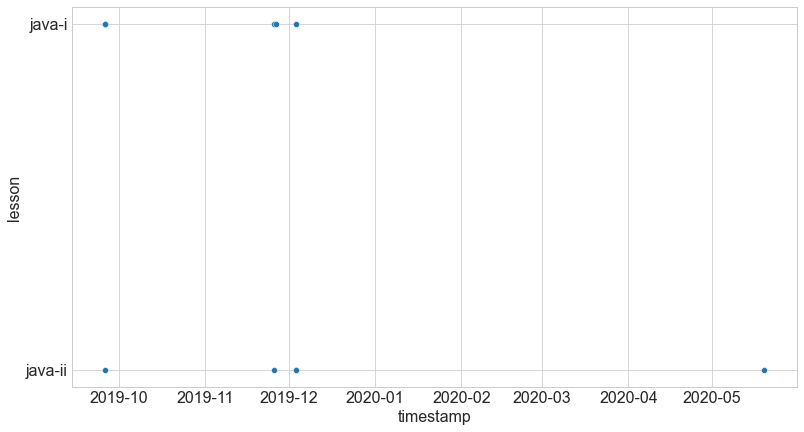

In [80]:
sns.scatterplot(data=dsweb, x='timestamp', y='lesson')

#### Q5 Answer
- note there was access in Bayes to Java i and Java ii
- also in Curie java ii
- no access from Darden

- 2 users in Bayes, all access within cohort session
- first user = 14 observations from Sept and November
- 2nd user = 3 observations in Dec

- 1 user in Curie, single access during cohort session


- not sure if "fundamentals" is used in both curriculum but as of 11/1/2020 there is a user in Bash who is accessing data science curriculum with lessons in anomaly-detection, classification, clustering, distributed-ml, nlp, python, regression, storytelling, and timeseries

- most other accesses are in 2019 or early 2020, but this current access indicates access has not yet been turned off across the board

### Q4 Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents?

oddities to investigate
- cohort 0 where cohort id was null should be looked at +44K

solved = 2/3 of occurrences for both of these are same 2 Codeup IP addresses = staff
- cohort 1 where there are 18 user_ids in use 4-6 years after graduation (+8K)
- cohort 14 where there are 12 user_ids in use 2-4 years after graduation (+9K)

- cohort 28 name = staff, ok to ignore +55K occurrences

In [81]:
exp.head()

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,0,9,Friday,26,1,2018,2016-02-06,2015-09-22
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,object-oriented-programming,9,Friday,26,1,2018,2016-02-06,2015-09-22
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,slides,object_oriented_programming,9,Friday,26,1,2018,2016-02-06,2015-09-22
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,conditionals,9,Friday,26,1,2018,2018-05-17,2018-01-08
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,javascript-i,loops,9,Friday,26,1,2018,2018-05-17,2018-01-08


In [82]:
# create df of just post graduation avtivity

post_grad = exp_not_ts[exp_not_ts.timestamp > exp_not_ts.end_date_ts]
post_grad.tail()

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
679322,2020-11-02 16:42:02,anomaly-detection/overview,11,28,76.185.145.231,Staff,2014-02-04,2014-02-04,2.0,anomaly-detection,overview,16,Monday,2,11,2020,2014-02-04,2014-02-04
679323,2020-11-02 16:42:02,anomaly-detection/AnomalyDetectionCartoon.jpeg,11,28,76.185.145.231,Staff,2014-02-04,2014-02-04,2.0,anomaly-detection,AnomalyDetectionCartoon.jpeg,16,Monday,2,11,2020,2014-02-04,2014-02-04
679324,2020-11-02 16:42:04,anomaly-detection/detecting-with-clustering,11,28,76.185.145.231,Staff,2014-02-04,2014-02-04,2.0,anomaly-detection,detecting-with-clustering,16,Monday,2,11,2020,2014-02-04,2014-02-04
679325,2020-11-02 16:42:06,anomaly-detection/detecting-timeseries-anomalies,11,28,76.185.145.231,Staff,2014-02-04,2014-02-04,2.0,anomaly-detection,detecting-timeseries-anomalies,16,Monday,2,11,2020,2014-02-04,2014-02-04
679326,2020-11-02 16:43:37,java-iii/mvc,211,28,136.50.63.72,Staff,2014-02-04,2014-02-04,2.0,java-iii,mvc,16,Monday,2,11,2020,2014-02-04,2014-02-04


In [83]:
post_grad.head()

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
0,2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,0,9,Friday,26,1,2018,2016-02-06,2015-09-22
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,object-oriented-programming,9,Friday,26,1,2018,2016-02-06,2015-09-22
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,slides,object_oriented_programming,9,Friday,26,1,2018,2016-02-06,2015-09-22
28,2018-01-26 10:14:51,javascript-i,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,javascript-i,0,10,Friday,26,1,2018,2014-04-22,2014-02-04
29,2018-01-26 10:15:02,javascript-i/functions,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,javascript-i,functions,10,Friday,26,1,2018,2014-04-22,2014-02-04


In [84]:
# summarize post grad?
# create dataframe by cohort with count of unique users, count of pages viewed, first date accessed, and
# last date accessed
post_grad_agg = post_grad.groupby(['cohort_id'])['program_id', 'start_date', 'end_date', 'user_id', 'page_viewed', 'timestamp'].\
                        agg({'program_id': ['min'], 'start_date': ['min'], 'end_date': ['min'], 'user_id' : ['nunique'], 'page_viewed': ['count'], 'timestamp' : ['min', 'max']})

# use this to unstack the column names
post_grad_agg.columns = [' '.join(col).strip() for col in post_grad_agg.columns.values]

# use this for multiple aggregation
# # df.agg({'A' : ['sum', 'min'], 'B' : ['min', 'max']})

In [85]:
post_grad_agg

,program_id min,start_date min,end_date min,user_id nunique,page_viewed count,timestamp min,timestamp max
cohort_id,,,,,,,
0,0.0,0,0,75,40792,2018-01-26 16:46:24,2020-11-02 16:30:49
1,1.0,2014-02-04,2014-04-22,18,8262,2018-01-26 10:14:51,2020-03-25 23:01:25
2,1.0,2014-06-04,2014-08-22,3,76,2018-03-19 03:10:04,2019-07-31 16:01:25
4,1.0,2014-10-20,2015-01-18,1,3,2018-02-04 11:23:27,2018-02-04 11:24:56
6,1.0,2015-02-03,2015-05-26,2,68,2018-10-16 03:57:11,2019-05-12 21:40:52
7,1.0,2015-06-05,2015-10-06,6,461,2018-01-31 19:10:00,2019-12-11 09:55:00
8,1.0,2015-09-22,2016-02-06,5,1502,2018-01-26 09:56:02,2020-04-28 10:58:40
9,4.0,2015-03-30,2015-07-29,1,4,2018-03-22 19:01:54,2018-03-22 19:02:52
11,1.0,2016-01-20,2016-05-12,5,200,2018-05-07 20:12:49,2020-07-20 00:42:28


In [86]:
post_grad[post_grad.IP == '97.105.19.58']

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
81310,2018-07-16 07:51:57,javascript-ii/promises,211,1,97.105.19.58,Arches,2014-02-04,2014-04-22,1.0,javascript-ii,promises,7,Monday,16,7,2018,2014-04-22,2014-02-04
81311,2018-07-16 07:58:03,javascript-ii/map-filter-reduce,211,1,97.105.19.58,Arches,2014-02-04,2014-04-22,1.0,javascript-ii,map-filter-reduce,7,Monday,16,7,2018,2014-04-22,2014-02-04
81312,2018-07-16 07:59:50,javascript-ii/promises,211,1,97.105.19.58,Arches,2014-02-04,2014-04-22,1.0,javascript-ii,promises,7,Monday,16,7,2018,2014-04-22,2014-02-04
81313,2018-07-16 08:07:37,index.html,53,14,97.105.19.58,Lassen,2016-07-18,2016-11-10,1.0,index.html,0,8,Monday,16,7,2018,2016-11-10,2016-07-18
81314,2018-07-16 08:07:41,javascript-ii,53,14,97.105.19.58,Lassen,2016-07-18,2016-11-10,1.0,javascript-ii,0,8,Monday,16,7,2018,2016-11-10,2016-07-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462916,2020-03-19 09:56:26,java-i/introduction-to-java,514,28,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0,java-i,introduction-to-java,9,Thursday,19,3,2020,2014-02-04,2014-02-04
465222,2020-03-23 09:51:54,toc,257,28,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0,toc,0,9,Monday,23,3,2020,2014-02-04,2014-02-04
465223,2020-03-23 09:51:58,html-css,257,28,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0,html-css,0,9,Monday,23,3,2020,2014-02-04,2014-02-04
465605,2020-03-23 12:34:03,html-css/introduction,257,28,97.105.19.58,Staff,2014-02-04,2014-02-04,2.0,html-css,introduction,12,Monday,23,3,2020,2014-02-04,2014-02-04


In [87]:
# cohort 1 where there are 18 user_ids in use 4-6 years after graduation (+8K)
c1_post = post_grad[post_grad.cohort_id == 1]
c1_post.nunique()

timestamp        7903
page_viewed       341
user_id            18
cohort_id           1
IP                 41
name                1
start_date          1
end_date            1
program_id          1
lesson             34
sub_lesson        113
hour               22
weekday             7
day                31
month              12
year                3
end_date_ts         1
start_date_ts       1
dtype: int64

In [88]:
c1_post.groupby('IP').count()
# primarily 2 IP addresses responsible for 2/3 of total activity = 97.105.19.58 and 97.105.19.61
# 7 user_ids used
# hit during 11 hours out of each day, 5 days per week, all days of month, for 6 - 7 months
# starts 1/26/2018 and continues to 7/13/2018
# starts 7/16/2018 and continues to 12/6/2018

,timestamp,page_viewed,user_id,cohort_id,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
IP,,,,,,,,,,,,,,,,,
107.77.196.213,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
107.77.217.196,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
107.77.217.65,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
107.77.66.81,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
108.199.117.96,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47
12.189.101.90,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
12.31.120.82,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
170.248.173.247,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
172.56.14.78,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [89]:
c1_post.groupby('IP').nunique()


,timestamp,page_viewed,user_id,cohort_id,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
IP,,,,,,,,,,,,,,,,,
107.77.196.213,4,5,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1
107.77.217.196,2,2,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1
107.77.217.65,6,6,1,1,1,1,1,1,2,5,2,1,1,1,1,1,1
107.77.66.81,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
108.199.117.96,47,38,1,1,1,1,1,1,9,20,3,5,6,2,1,1,1
12.189.101.90,6,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
12.31.120.82,5,1,1,1,1,1,1,1,1,1,4,2,4,3,1,1,1
170.248.173.247,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
172.56.14.78,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [90]:
c1_post[(c1_post.IP == '97.105.19.58')]

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
81310,2018-07-16 07:51:57,javascript-ii/promises,211,1,97.105.19.58,Arches,2014-02-04,2014-04-22,1.0,javascript-ii,promises,7,Monday,16,7,2018,2014-04-22,2014-02-04
81311,2018-07-16 07:58:03,javascript-ii/map-filter-reduce,211,1,97.105.19.58,Arches,2014-02-04,2014-04-22,1.0,javascript-ii,map-filter-reduce,7,Monday,16,7,2018,2014-04-22,2014-02-04
81312,2018-07-16 07:59:50,javascript-ii/promises,211,1,97.105.19.58,Arches,2014-02-04,2014-04-22,1.0,javascript-ii,promises,7,Monday,16,7,2018,2014-04-22,2014-02-04
81316,2018-07-16 08:13:09,javascript-ii/map-filter-reduce,211,1,97.105.19.58,Arches,2014-02-04,2014-04-22,1.0,javascript-ii,map-filter-reduce,8,Monday,16,7,2018,2014-04-22,2014-02-04
81359,2018-07-16 09:08:13,javascript-ii/npm,211,1,97.105.19.58,Arches,2014-02-04,2014-04-22,1.0,javascript-ii,npm,9,Monday,16,7,2018,2014-04-22,2014-02-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157789,2018-12-06 11:09:48,java-iii,11,1,97.105.19.58,Arches,2014-02-04,2014-04-22,1.0,java-iii,0,11,Thursday,6,12,2018,2014-04-22,2014-02-04
157797,2018-12-06 11:13:39,appendix,11,1,97.105.19.58,Arches,2014-02-04,2014-04-22,1.0,appendix,0,11,Thursday,6,12,2018,2014-04-22,2014-02-04
157799,2018-12-06 11:14:11,appendix/extra-challenges/sales-tax,11,1,97.105.19.58,Arches,2014-02-04,2014-04-22,1.0,appendix,extra-challenges,11,Thursday,6,12,2018,2014-04-22,2014-02-04
157865,2018-12-06 13:37:44,javascript-i,64,1,97.105.19.58,Arches,2014-02-04,2014-04-22,1.0,javascript-i,0,13,Thursday,6,12,2018,2014-04-22,2014-02-04


In [91]:
c1_post[c1_post.IP == '97.105.19.61']

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
28,2018-01-26 10:14:51,javascript-i,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,javascript-i,0,10,Friday,26,1,2018,2014-04-22,2014-02-04
29,2018-01-26 10:15:02,javascript-i/functions,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,javascript-i,functions,10,Friday,26,1,2018,2014-04-22,2014-02-04
122,2018-01-26 11:46:29,appendix/further-reading/javascript/hoisting.html,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,appendix,further-reading,11,Friday,26,1,2018,2014-04-22,2014-02-04
124,2018-01-26 11:46:39,appendix,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,appendix,0,11,Friday,26,1,2018,2014-04-22,2014-02-04
127,2018-01-26 11:46:47,appendix/further-reading/javascript/hoisting,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,appendix,further-reading,11,Friday,26,1,2018,2014-04-22,2014-02-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80903,2018-07-13 11:53:59,javascript-ii/map-filter-reduce,64,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,javascript-ii,map-filter-reduce,11,Friday,13,7,2018,2014-04-22,2014-02-04
81034,2018-07-13 15:30:59,javascript-ii,64,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,javascript-ii,0,15,Friday,13,7,2018,2014-04-22,2014-02-04
81035,2018-07-13 15:31:01,javascript-ii/es6,64,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,javascript-ii,es6,15,Friday,13,7,2018,2014-04-22,2014-02-04
81047,2018-07-13 15:49:18,javascript-ii/promises,64,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,javascript-ii,promises,15,Friday,13,7,2018,2014-04-22,2014-02-04


In [92]:
# cohort 14 where there are 12 user_ids in use 2-4 years after graduation (+9K)
c14_post = post_grad[post_grad.cohort_id == 14]
c14_post.nunique()


timestamp        9139
page_viewed       477
user_id            12
cohort_id           1
IP                 32
name                1
start_date          1
end_date            1
program_id          1
lesson             50
sub_lesson        135
hour               23
weekday             7
day                31
month              12
year                3
end_date_ts         1
start_date_ts       1
dtype: int64

In [93]:
c14_post.groupby('IP').count()
# SAME! 2 IP addresses as in cohort1 responsible for 2/3 of total activity = 97.105.19.58 and 97.105.19.61
# 1 user_id used
# hit during 11-12 hours out of each day, 5 days per week, all days of month, for 7 - 12 months
# first IP starts Jan 29, 2018 and continues to July 13, 2018
# second IP starts July 16, 2018 and continues to Jan 23, 2020

,timestamp,page_viewed,user_id,cohort_id,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
IP,,,,,,,,,,,,,,,,,
107.77.210.31,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
107.77.221.110,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
136.50.29.193,361,361,361,361,361,361,361,361,361,361,361,361,361,361,361,361,361
167.24.104.150,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
173.174.212.111,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
173.175.82.174,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
174.197.1.248,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
192.171.117.210,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127
209.64.120.2,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27


In [94]:
c14_post.groupby('IP').nunique()

,timestamp,page_viewed,user_id,cohort_id,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
IP,,,,,,,,,,,,,,,,,
107.77.210.31,3,4,1,1,1,1,1,1,2,2,2,2,2,1,1,1,1
107.77.221.110,2,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1
136.50.29.193,309,108,1,1,1,1,1,1,5,17,16,7,22,11,3,1,1
167.24.104.150,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
173.174.212.111,16,6,1,1,1,1,1,1,4,3,3,1,1,1,1,1,1
173.175.82.174,23,12,1,1,1,1,1,1,1,8,2,1,1,1,1,1,1
174.197.1.248,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
192.171.117.210,114,73,3,1,1,1,1,1,11,20,7,5,7,6,2,1,1
209.64.120.2,27,11,1,1,1,1,1,1,7,7,3,2,5,4,2,1,1


In [95]:
c14_post[(c14_post.IP == '97.105.19.58')]

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
81313,2018-07-16 08:07:37,index.html,53,14,97.105.19.58,Lassen,2016-07-18,2016-11-10,1.0,index.html,0,8,Monday,16,7,2018,2016-11-10,2016-07-18
81314,2018-07-16 08:07:41,javascript-ii,53,14,97.105.19.58,Lassen,2016-07-18,2016-11-10,1.0,javascript-ii,0,8,Monday,16,7,2018,2016-11-10,2016-07-18
81315,2018-07-16 08:07:43,javascript-ii/promises,53,14,97.105.19.58,Lassen,2016-07-18,2016-11-10,1.0,javascript-ii,promises,8,Monday,16,7,2018,2016-11-10,2016-07-18
81317,2018-07-16 08:19:03,index.html,53,14,97.105.19.58,Lassen,2016-07-18,2016-11-10,1.0,index.html,0,8,Monday,16,7,2018,2016-11-10,2016-07-18
81318,2018-07-16 08:19:05,javascript-i,53,14,97.105.19.58,Lassen,2016-07-18,2016-11-10,1.0,javascript-i,0,8,Monday,16,7,2018,2016-11-10,2016-07-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413005,2020-01-22 13:33:12,spring/fundamentals/form-model-binding,53,14,97.105.19.58,Lassen,2016-07-18,2016-11-10,1.0,spring,fundamentals,13,Wednesday,22,1,2020,2016-11-10,2016-07-18
414030,2020-01-23 09:47:35,index.html,53,14,97.105.19.58,Lassen,2016-07-18,2016-11-10,1.0,index.html,0,9,Thursday,23,1,2020,2016-11-10,2016-07-18
414031,2020-01-23 09:47:41,java-ii,53,14,97.105.19.58,Lassen,2016-07-18,2016-11-10,1.0,java-ii,0,9,Thursday,23,1,2020,2016-11-10,2016-07-18
414032,2020-01-23 09:47:42,java-ii/inheritance-and-polymorphism,53,14,97.105.19.58,Lassen,2016-07-18,2016-11-10,1.0,java-ii,inheritance-and-polymorphism,9,Thursday,23,1,2020,2016-11-10,2016-07-18


In [96]:
c14_post[c14_post.IP == '97.105.19.61']

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
902,2018-01-29 08:51:48,index.html,53,14,97.105.19.61,Lassen,2016-07-18,2016-11-10,1.0,index.html,0,8,Monday,29,1,2018,2016-11-10,2016-07-18
903,2018-01-29 08:51:51,javascript-i,53,14,97.105.19.61,Lassen,2016-07-18,2016-11-10,1.0,javascript-i,0,8,Monday,29,1,2018,2016-11-10,2016-07-18
936,2018-01-29 09:10:46,javascript-i/conditionals,53,14,97.105.19.61,Lassen,2016-07-18,2016-11-10,1.0,javascript-i,conditionals,9,Monday,29,1,2018,2016-11-10,2016-07-18
1302,2018-01-29 13:59:30,index.html,53,14,97.105.19.61,Lassen,2016-07-18,2016-11-10,1.0,index.html,0,13,Monday,29,1,2018,2016-11-10,2016-07-18
1306,2018-01-29 14:02:13,javascript-i,53,14,97.105.19.61,Lassen,2016-07-18,2016-11-10,1.0,javascript-i,0,14,Monday,29,1,2018,2016-11-10,2016-07-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80829,2018-07-13 10:53:39,javascript-ii,53,14,97.105.19.61,Lassen,2016-07-18,2016-11-10,1.0,javascript-ii,0,10,Friday,13,7,2018,2016-11-10,2016-07-18
80830,2018-07-13 10:53:42,javascript-ii/promises,53,14,97.105.19.61,Lassen,2016-07-18,2016-11-10,1.0,javascript-ii,promises,10,Friday,13,7,2018,2016-11-10,2016-07-18
80856,2018-07-13 11:33:38,index.html,53,14,97.105.19.61,Lassen,2016-07-18,2016-11-10,1.0,index.html,0,11,Friday,13,7,2018,2016-11-10,2016-07-18
80857,2018-07-13 11:33:41,javascript-ii,53,14,97.105.19.61,Lassen,2016-07-18,2016-11-10,1.0,javascript-ii,0,11,Friday,13,7,2018,2016-11-10,2016-07-18


In [97]:
# drop Codeup IP address from dataframe
post_grad2 = post_grad.copy()
post_grad2.drop(post_grad[post_grad['IP'] == '97.105.19.61'].index, inplace = True)
post_grad2.drop(post_grad[post_grad['IP'] == '97.105.19.58'].index, inplace = True)

post_grad2.shape

(123081, 18)

In [98]:
# re-summarize post grad

post_grad_agg2 = post_grad2.groupby(['cohort_id'])['program_id', 'start_date', 'end_date', 'user_id', 'page_viewed', 'timestamp'].\
                        agg({'program_id': ['min'], 'start_date': ['min'], 'end_date': ['min'], 'user_id' : ['nunique'], 'page_viewed': ['count'], 'timestamp' : ['min', 'max']})

# use this to unstack the column names
post_grad_agg2.columns = [' '.join(col).strip() for col in post_grad_agg.columns.values]

# use this for multiple aggregation
# # df.agg({'A' : ['sum', 'min'], 'B' : ['min', 'max']})

In [99]:
post_grad_agg2

,p r o g r a m _ i d m i n,s t a r t _ d a t e m i n,e n d _ d a t e m i n,u s e r _ i d n u n i q u e,p a g e _ v i e w e d c o u n t,t i m e s t a m p m i n,t i m e s t a m p m a x
cohort_id,,,,,,,
0,0.0,0,0,74,25014,2018-01-28 23:43:12,2020-11-02 16:30:49
1,1.0,2014-02-04,2014-04-22,15,1174,2018-02-10 11:01:13,2020-03-25 23:01:25
2,1.0,2014-06-04,2014-08-22,3,76,2018-03-19 03:10:04,2019-07-31 16:01:25
4,1.0,2014-10-20,2015-01-18,1,3,2018-02-04 11:23:27,2018-02-04 11:24:56
6,1.0,2015-02-03,2015-05-26,2,68,2018-10-16 03:57:11,2019-05-12 21:40:52
7,1.0,2015-06-05,2015-10-06,6,376,2018-01-31 19:10:00,2019-12-11 09:55:00
8,1.0,2015-09-22,2016-02-06,5,303,2018-01-27 07:49:25,2020-04-28 10:58:40
9,4.0,2015-03-30,2015-07-29,1,4,2018-03-22 19:01:54,2018-03-22 19:02:52
11,1.0,2016-01-20,2016-05-12,5,200,2018-05-07 20:12:49,2020-07-20 00:42:28


In [100]:
post_grad2[post_grad2.cohort_id == 28].nunique()

timestamp        31938
page_viewed       1027
user_id             34
cohort_id            1
IP                 220
name                 1
start_date           1
end_date             1
program_id           1
lesson             239
sub_lesson         435
hour                24
weekday              7
day                 31
month               12
year                 3
end_date_ts          1
start_date_ts        1
dtype: int64

In [101]:
# cohort 1 where there are 15 user_ids in use 4-6 years after graduation (+1K)
c1_post2 = post_grad2[post_grad2.cohort_id == 1]
c1_post2.groupby('IP').nunique()

,timestamp,page_viewed,user_id,cohort_id,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
IP,,,,,,,,,,,,,,,,,
107.77.196.213,4,5,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1
107.77.217.196,2,2,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1
107.77.217.65,6,6,1,1,1,1,1,1,2,5,2,1,1,1,1,1,1
107.77.66.81,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
108.199.117.96,47,38,1,1,1,1,1,1,9,20,3,5,6,2,1,1,1
12.189.101.90,6,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
12.31.120.82,5,1,1,1,1,1,1,1,1,1,4,2,4,3,1,1,1
170.248.173.247,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
172.56.14.78,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [102]:
# cohort 13 where there are 9 user_ids in use 2-4 years after graduation (+2K)
c13_post2 = post_grad2[post_grad2.cohort_id == 13]
c13_post2.groupby('IP').nunique()

,timestamp,page_viewed,user_id,cohort_id,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
IP,,,,,,,,,,,,,,,,,
104.191.12.108,30,19,1,1,1,1,1,1,6,10,4,2,4,3,2,1,1
104.48.141.55,142,93,1,1,1,1,1,1,2,7,6,5,6,1,1,1,1
12.197.199.226,74,46,1,1,1,1,1,1,1,4,6,3,3,1,1,1,1
137.242.1.128,12,12,1,1,1,1,1,1,2,11,2,1,1,1,1,1,1
137.242.1.129,5,5,1,1,1,1,1,1,2,4,1,1,1,1,1,1,1
167.24.24.150,11,7,1,1,1,1,1,1,5,4,3,1,1,1,1,1,1
172.56.7.193,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
172.58.100.127,7,9,1,1,1,1,1,1,1,3,1,1,1,1,1,1,1
172.58.100.195,35,32,1,1,1,1,1,1,1,8,2,1,1,1,1,1,1


In [103]:
# cohort 14 where there are 12 user_ids in use 2-4 years after graduation (+2K)
c14_post2 = post_grad2[post_grad2.cohort_id == 14]
c14_post2.groupby('IP').nunique()

,timestamp,page_viewed,user_id,cohort_id,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
IP,,,,,,,,,,,,,,,,,
107.77.210.31,3,4,1,1,1,1,1,1,2,2,2,2,2,1,1,1,1
107.77.221.110,2,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1
136.50.29.193,309,108,1,1,1,1,1,1,5,17,16,7,22,11,3,1,1
167.24.104.150,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
173.174.212.111,16,6,1,1,1,1,1,1,4,3,3,1,1,1,1,1,1
173.175.82.174,23,12,1,1,1,1,1,1,1,8,2,1,1,1,1,1,1
174.197.1.248,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
192.171.117.210,114,73,3,1,1,1,1,1,11,20,7,5,7,6,2,1,1
209.64.120.2,27,11,1,1,1,1,1,1,7,7,3,2,5,4,2,1,1


In [104]:
# cohort 23 where there are 26 user_ids in use 2 years after graduation (+3K)
c23_post2 = post_grad2[post_grad2.cohort_id == 23]
c23_post2.groupby('IP').nunique()

,timestamp,page_viewed,user_id,cohort_id,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
IP,,,,,,,,,,,,,,,,,
104.1.46.153,9,6,2,1,1,1,1,1,2,5,4,3,3,2,1,1,1
104.180.86.144,21,12,1,1,1,1,1,1,5,6,6,5,6,3,1,1,1
104.190.250.60,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
104.48.213.175,33,24,1,1,1,1,1,1,7,10,7,4,5,2,1,1,1
104.5.221.205,4,4,1,1,1,1,1,1,3,4,2,2,2,1,1,1,1
107.77.105.75,2,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1
107.77.217.123,12,10,1,1,1,1,1,1,5,6,2,2,2,2,1,1,1
107.77.217.226,7,7,1,1,1,1,1,1,1,7,1,1,1,1,1,1,1
107.77.218.10,5,3,1,1,1,1,1,1,2,2,1,1,1,1,1,1,1


In [105]:
post_grad2[(post_grad2.IP == '192.171.117.210')].groupby('user_id')[['timestamp']].agg(['min', 'max'])

timestamp                    
                        min                 max
user_id                                        
1       2019-03-01 10:47:25 2019-07-10 13:28:31
11      2018-07-30 10:06:04 2019-07-10 16:55:00
37      2018-01-26 12:37:54 2018-05-14 15:16:44
40      2018-07-30 14:38:30 2018-07-30 14:38:30
41      2018-07-30 10:12:29 2019-06-28 11:25:14
51      2018-02-15 19:07:00 2018-02-15 19:07:00
53      2018-02-15 16:10:01 2019-03-01 13:16:07
58      2018-02-15 16:04:21 2018-02-15 16:04:35
60      2018-02-15 16:54:17 2018-02-15 17:26:37
64      2018-02-15 16:17:06 2019-03-01 15:32:28
69      2018-01-30 12:44:58 2018-02-07 14:11:42
76      2018-01-31 17:42:45 2018-01-31 17:43:25
79      2018-03-12 09:56:54 2018-06-12 16:16:51
88      2018-09-27 10:32:51 2018-10-24 12:09:29
105     2018-10-01 12:04:30 2018-10-01 12:05:04
108     2018-02-21 16:18:31 2018-03-02 15:56:49
110     2018-08-04 12:43:43 2018-08-04 14:45:34
111     2018-05-08 11:47:22 2018-05-08 15:09:21
127     2018-08-28 19:07:39 2018-08-28 19:07:50
130     2018-07-23 12:39:36 2018-07-23 12:39:36
138     2018-05-30 15:28:05 2018-05-30 15:28:09
139     2018-03-12 12:42:43 2018-04-30 14:25:50
142     2018-07-01 10:13:24 2018-08-27 18:48:24
145     2018-07-25 11:13:13 2018-07-25 11:13:18
148     2018-11-05 09:12:38 2018-11-05 09:13:01
151     2018-03-20 18:49:58 2018-03-20 18:49:58
157     2018-08-22 12:20:35 2018-10-03 17:42:36
164     2018-03-30 11:47:19 2018-03-30 12:44:20
171     2019-08-21 18:15:07 2019-08-21 18:15:29
179     2018-05-14 15:16:10 2018-05-24 10:11:53
180     2018-05-21 13:24:32 2018-05-21 13:24:50
186     2018-11-10 14:10:37 2018-11-10 14:11:44
193     2019-12-07 15:16:35 2019-12-07 15:16:56
211     2018-07-30 08:52:12 2019-12-09 07:42:19
248     2019-03-01 08:50:28 2019-07-10 13:34:15
263     2019-02-21 10:22:45 2019-02-21 10:50:14
271     2019-03-01 13:21:40 2019-03-01 13:22:19
279     2018-10-01 13:40:25 2018-10-01 13:40:47
280     2018-10-03 10:45:07 2018-10-03 13:25:24
302     2019-04-29 17:18:04 2019-06-04 14:23:08
314     2019-03-01 11:40:33 2019-07-14 20:14:05
332     2019-06-07 13:30:49 2019-06-16 13:36:23
335     2019-06-16 14:29:56 2019-06-16 16:12:26
338     2019-06-16 14:31:58 2019-06-16 14:31:58
346     2020-01-27 22:22:48 2020-01-27 22:23:03
351     2019-04-03 21:29:00 2019-04-24 20:12:57
352     2019-06-07 13:09:47 2019-07-26 15:17:31
353     2019-02-23 22:38:38 2019-04-13 21:24:05
354     2019-02-11 17:15:43 2019-05-07 07:31:11
355     2019-03-23 15:38:47 2019-03-23 15:38:47
357     2019-03-11 17:37:41 2019-05-09 17:38:32
358     2020-02-26 14:15:23 2020-03-15 13:51:51
359     2019-03-23 14:34:48 2019-04-22 17:56:05
362     2019-04-04 17:40:40 2019-04-11 17:48:38
363     2019-02-21 17:43:09 2019-11-18 15:14:37
364     2019-04-13 20:15:28 2019-04-13 22:12:51
365     2019-02-14 17:56:47 2019-02-14 18:06:51
366     2019-02-25 17:19:57 2019-07-19 15:26:31
369     2019-03-14 17:19:35 2019-07-19 14:25:45
370     2019-03-05 14:26:02 2019-03-05 14:27:12
372     2019-03-23 17:17:17 2019-08-22 11:41:47
403     2019-05-19 12:43:29 2019-07-23 14:46:08
423     2019-10-11 11:00:37 2019-10-11 11:05:30
424     2019-10-14 10:25:35 2019-11-11 13:32:36
428     2019-11-09 12:01:29 2019-11-09 12:01:38
464     2019-10-28 11:45:08 2019-10-28 12:07:41
474     2020-02-24 16:03:53 2020-02-24 16:04:09
477     2020-03-05 17:13:55 2020-03-05 17:13:55
490     2020-03-02 13:25:17 2020-03-10 16:07:37
491     2020-03-11 21:17:59 2020-03-11 22:13:16
500     2020-03-02 13:42:48 2020-03-02 16:19:02
504     2020-03-02 16:16:05 2020-03-02 16:18:52
506     2020-08-10 12:28:56 2020-08-27 13:10:52
508     2020-07-29 13:42:00 2020-08-13 12:22:08
544     2019-12-03 11:32:22 2020-02-11 13:55:18
572     2020-01-18 13:26:42 2020-01-18 13:27:28

#### Q4 Answers
oddities to investigate
- cohort 0 where cohort id was null should be looked at +44K

solved = 2/3 of occurrences for both of these are same 2 Codeup IP addresses = staff
- cohort 1 where there are 18 user_ids in use 4-6 years after graduation (+8K)
- cohort 14 where there are 12 user_ids in use 2-4 years after graduation (+9K)

solved = these are all staff
- cohort 28 name = staff, ok to ignore +55K occurrences


unable to find any other oddities, large amounts of pages and/or user_ids trace back to telecom companies like Spectrum, Aethernet, AT&T, MCI, etc. where user IP address is likely masked by provider

### Q6 What topics are grads continuing to reference after graduation and into their jobs (for each program)? 

In [106]:
exp_not_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679337 entries, 0 to 679336
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   timestamp      679337 non-null  datetime64[ns]
 1   page_viewed    679337 non-null  object        
 2   user_id        679337 non-null  int64         
 3   cohort_id      679337 non-null  int64         
 4   IP             679337 non-null  object        
 5   name           679337 non-null  object        
 6   start_date     679337 non-null  object        
 7   end_date       679337 non-null  object        
 8   program_id     679337 non-null  float64       
 9   lesson         679337 non-null  object        
 10  sub_lesson     679337 non-null  object        
 11  hour           679337 non-null  int64         
 12  weekday        679337 non-null  object        
 13  day            679337 non-null  int64         
 14  month          679337 non-null  int64         
 15  

In [107]:
# exp_not_ts['end_date_ts'] = pd.to_datetime(exp_not_ts.end_date)

In [108]:
# create dataframe of only post graduation accesses
post = exp_not_ts[exp_not_ts.timestamp > exp_not_ts.end_date_ts]
post


,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
0,2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,0,9,Friday,26,1,2018,2016-02-06,2015-09-22
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,java-ii,object-oriented-programming,9,Friday,26,1,2018,2016-02-06,2015-09-22
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,slides,object_oriented_programming,9,Friday,26,1,2018,2016-02-06,2015-09-22
28,2018-01-26 10:14:51,javascript-i,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,javascript-i,0,10,Friday,26,1,2018,2014-04-22,2014-02-04
29,2018-01-26 10:15:02,javascript-i/functions,11,1,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,javascript-i,functions,10,Friday,26,1,2018,2014-04-22,2014-02-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679322,2020-11-02 16:42:02,anomaly-detection/overview,11,28,76.185.145.231,Staff,2014-02-04,2014-02-04,2.0,anomaly-detection,overview,16,Monday,2,11,2020,2014-02-04,2014-02-04
679323,2020-11-02 16:42:02,anomaly-detection/AnomalyDetectionCartoon.jpeg,11,28,76.185.145.231,Staff,2014-02-04,2014-02-04,2.0,anomaly-detection,AnomalyDetectionCartoon.jpeg,16,Monday,2,11,2020,2014-02-04,2014-02-04
679324,2020-11-02 16:42:04,anomaly-detection/detecting-with-clustering,11,28,76.185.145.231,Staff,2014-02-04,2014-02-04,2.0,anomaly-detection,detecting-with-clustering,16,Monday,2,11,2020,2014-02-04,2014-02-04
679325,2020-11-02 16:42:06,anomaly-detection/detecting-timeseries-anomalies,11,28,76.185.145.231,Staff,2014-02-04,2014-02-04,2.0,anomaly-detection,detecting-timeseries-anomalies,16,Monday,2,11,2020,2014-02-04,2014-02-04


In [109]:
# filter for only data science
ds2 = post[post.program_id == 3]
ds2.head()

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
419515,2020-01-30 08:01:31,1-fundamentals/1.1-intro-to-data-science,485,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,fundamentals,1.1-intro-to-data-science,8,Thursday,30,1,2020,2020-01-30,2019-08-19
419516,2020-01-30 08:01:32,1-fundamentals/modern-data-scientist.jpg,485,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,fundamentals,modern-data-scientist.jpg,8,Thursday,30,1,2020,2020-01-30,2019-08-19
419517,2020-01-30 08:01:32,1-fundamentals/AI-ML-DL-timeline.jpg,485,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,fundamentals,AI-ML-DL-timeline.jpg,8,Thursday,30,1,2020,2020-01-30,2019-08-19
420686,2020-01-31 11:05:13,1-fundamentals/1.1-intro-to-data-science,476,34,136.50.49.145,Bayes,2019-08-19,2020-01-30,3.0,fundamentals,1.1-intro-to-data-science,11,Friday,31,1,2020,2020-01-30,2019-08-19
420687,2020-01-31 11:05:13,1-fundamentals/modern-data-scientist.jpg,476,34,136.50.49.145,Bayes,2019-08-19,2020-01-30,3.0,fundamentals,modern-data-scientist.jpg,11,Friday,31,1,2020,2020-01-30,2019-08-19


In [110]:
dslesson_post = ds2.groupby(['lesson'])[['sub_lesson']].count().reset_index()
dslesson_post.sort_values(by='sub_lesson', ascending = False)

,lesson,sub_lesson
13,sql,884
7,fundamentals,684
3,classification,586
11,regression,495
10,python,414
14,stats,319
16,timeseries,286
12,search,250
1,anomaly-detection,249
2,appendix,219


In [111]:
all_post = post.groupby(['lesson'])[['sub_lesson']].count().reset_index()
all_post.sort_values(by='sub_lesson', ascending = False).head(25)

,lesson,sub_lesson
414,javascript-i,19119
480,spring,15364
396,html-css,15000
442,mysql,13443
410,java-ii,10746
418,jquery,10031
323,appendix,9673
411,java-iii,9401
409,java-i,8777
352,content,8321


#### Q6 Answers

- for data science most common lesson post graduation = SQL!

- for all = Javascript-i (almost 20K), spring and html-css both at 15K

### Cohort 0

In [114]:
null_cohort = exp[exp.cohort_id == 0]
null_cohort.nunique()

page_viewed      1041
user_id            75
cohort_id           1
IP                314
name                1
start_date          1
end_date            1
program_id          1
lesson            357
sub_lesson        326
hour               24
weekday             7
day                31
month              12
year                3
end_date_ts         1
start_date_ts       1
dtype: int64

In [121]:
null_cohort.head()

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,lesson,sub_lesson,hour,weekday,day,month,year,end_date_ts,start_date_ts
timestamp,,,,,,,,,,,,,,,,,
2018-01-26 16:46:24,spring/extra-features/form-validation,48,0,97.105.19.61,0,0,0,0.0,spring,extra-features,16,Friday,26,1,2018,1970-01-01,1970-01-01
2018-01-26 18:32:17,mysql/relationships/joins,48,0,97.105.19.61,0,0,0,0.0,mysql,relationships,18,Friday,26,1,2018,1970-01-01,1970-01-01
2018-01-26 18:32:33,mysql/tables,48,0,97.105.19.61,0,0,0,0.0,mysql,tables,18,Friday,26,1,2018,1970-01-01,1970-01-01
2018-01-26 18:32:37,mysql/databases,48,0,97.105.19.61,0,0,0,0.0,mysql,databases,18,Friday,26,1,2018,1970-01-01,1970-01-01
2018-01-26 18:32:43,mysql/relationships,48,0,97.105.19.61,0,0,0,0.0,mysql,relationships,18,Friday,26,1,2018,1970-01-01,1970-01-01


In [125]:
# summarize null_cohort

null_sum = null_cohort.groupby(['user_id'])['IP', 'page_viewed'].\
                        agg({'IP': ['nunique'], 'page_viewed': ['count']})

# use this to unstack the column names
null_sum.columns = [' '.join(col).strip() for col in null_sum.columns.values]

# use this for multiple aggregation
# # df.agg({'A' : ['sum', 'min'], 'B' : ['min', 'max']})

In [126]:
null_sum

,IP nunique,page_viewed count
user_id,,
48,6,1466
54,5,130
58,11,420
59,4,41
61,9,811
62,1,3
63,3,17
64,2,14
73,4,77
